# Frequency-Dependent Claim Sizes

In this example, we look at a compound sum where the claim frequency and the claim sizes are dependent.

Specifically, let's say that the claim frequency variables are Negative Binomial distributed 

$$
N_i \overset{\mathrm{i.i.d.}}{\sim} \textsf{Poisson}(\lambda), \quad i = 1, \dots, T
$$ 

and the individual claim sizes are freqency dependent exponential, which means that 

$$
U_{i,1} \ldots, U_{i, N_i} \,|\, N_i \overset{\mathrm{i.i.d.}}{\sim} \textsf{Exp}(\beta\times \mathrm{e}^{\delta N_i}), \quad i = 1, \dots, T.
$$ 

The available data is the total claim sizes

$$
X_i = \sum_{j = 1}^{N_i} U_{i,j}, \quad i = 1, \ldots, T.
$$

## Generating some synthetic data to fit

We start by importing some necessary packages.

In [1]:
%config InlineBackend.figure_format = 'retina'
import approxbayescomp as abc
import numpy as np
import numpy.random as rnd

We will fit simulated data, so that we know the true value of the parameters for the data-generating process.
Here, we start with $\lambda = 4$, $\beta = 2$, and $\delta = 0.2$, and say that we observe $T = 100$ i.i.d. observations of the compound sum.

In [2]:
# Create a pseudorandom number generator
rg = rnd.default_rng(1234)

# Parameters of the true model
freq = "poisson"
sev = "frequency dependent exponential"
λ = 4
β = 2
δ = 0.2
trueTheta = (λ, β, δ)

# Setting the time horizon
T = 100

# Simulating the claim data
freqs, sevs = abc.simulate_claim_data(rg, T, freq, sev, trueTheta)

# Simulating the observed data
psi = abc.Psi("sum")
xData = abc.compute_psi(freqs, sevs, psi)

We can see if any of this observed data contains pesky zeros:

In [3]:
np.sum(xData == 0)

3

## Use ABC to fit both the frequency and claim size distributions

With this data, we create objects to represent the data-generating process (the model) and the prior distribution.
The priors are set as $\lambda \sim \mathsf{Unif}(0, 10)$, $\beta \sim \mathsf{Unif}(0, 20)$, and $\delta \sim \mathsf{Unif}(-1, 1).$

In [4]:
model = abc.Model(freq, sev, psi)
prior = abc.IndependentUniformPrior([(0, 10), (0, 20), (-1, 1)], ("λ", "β", "δ"))

After, we call the main `smc` method which is provided by `approxbayescomp` to fit the observed `xData`.

In [6]:
numIters = 10
popSize = 100
%time fit = abc.smc(numIters, popSize, xData, model, prior, seed=1)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 16.4 s, sys: 15.3 ms, total: 16.4 s
Wall time: 16.4 s


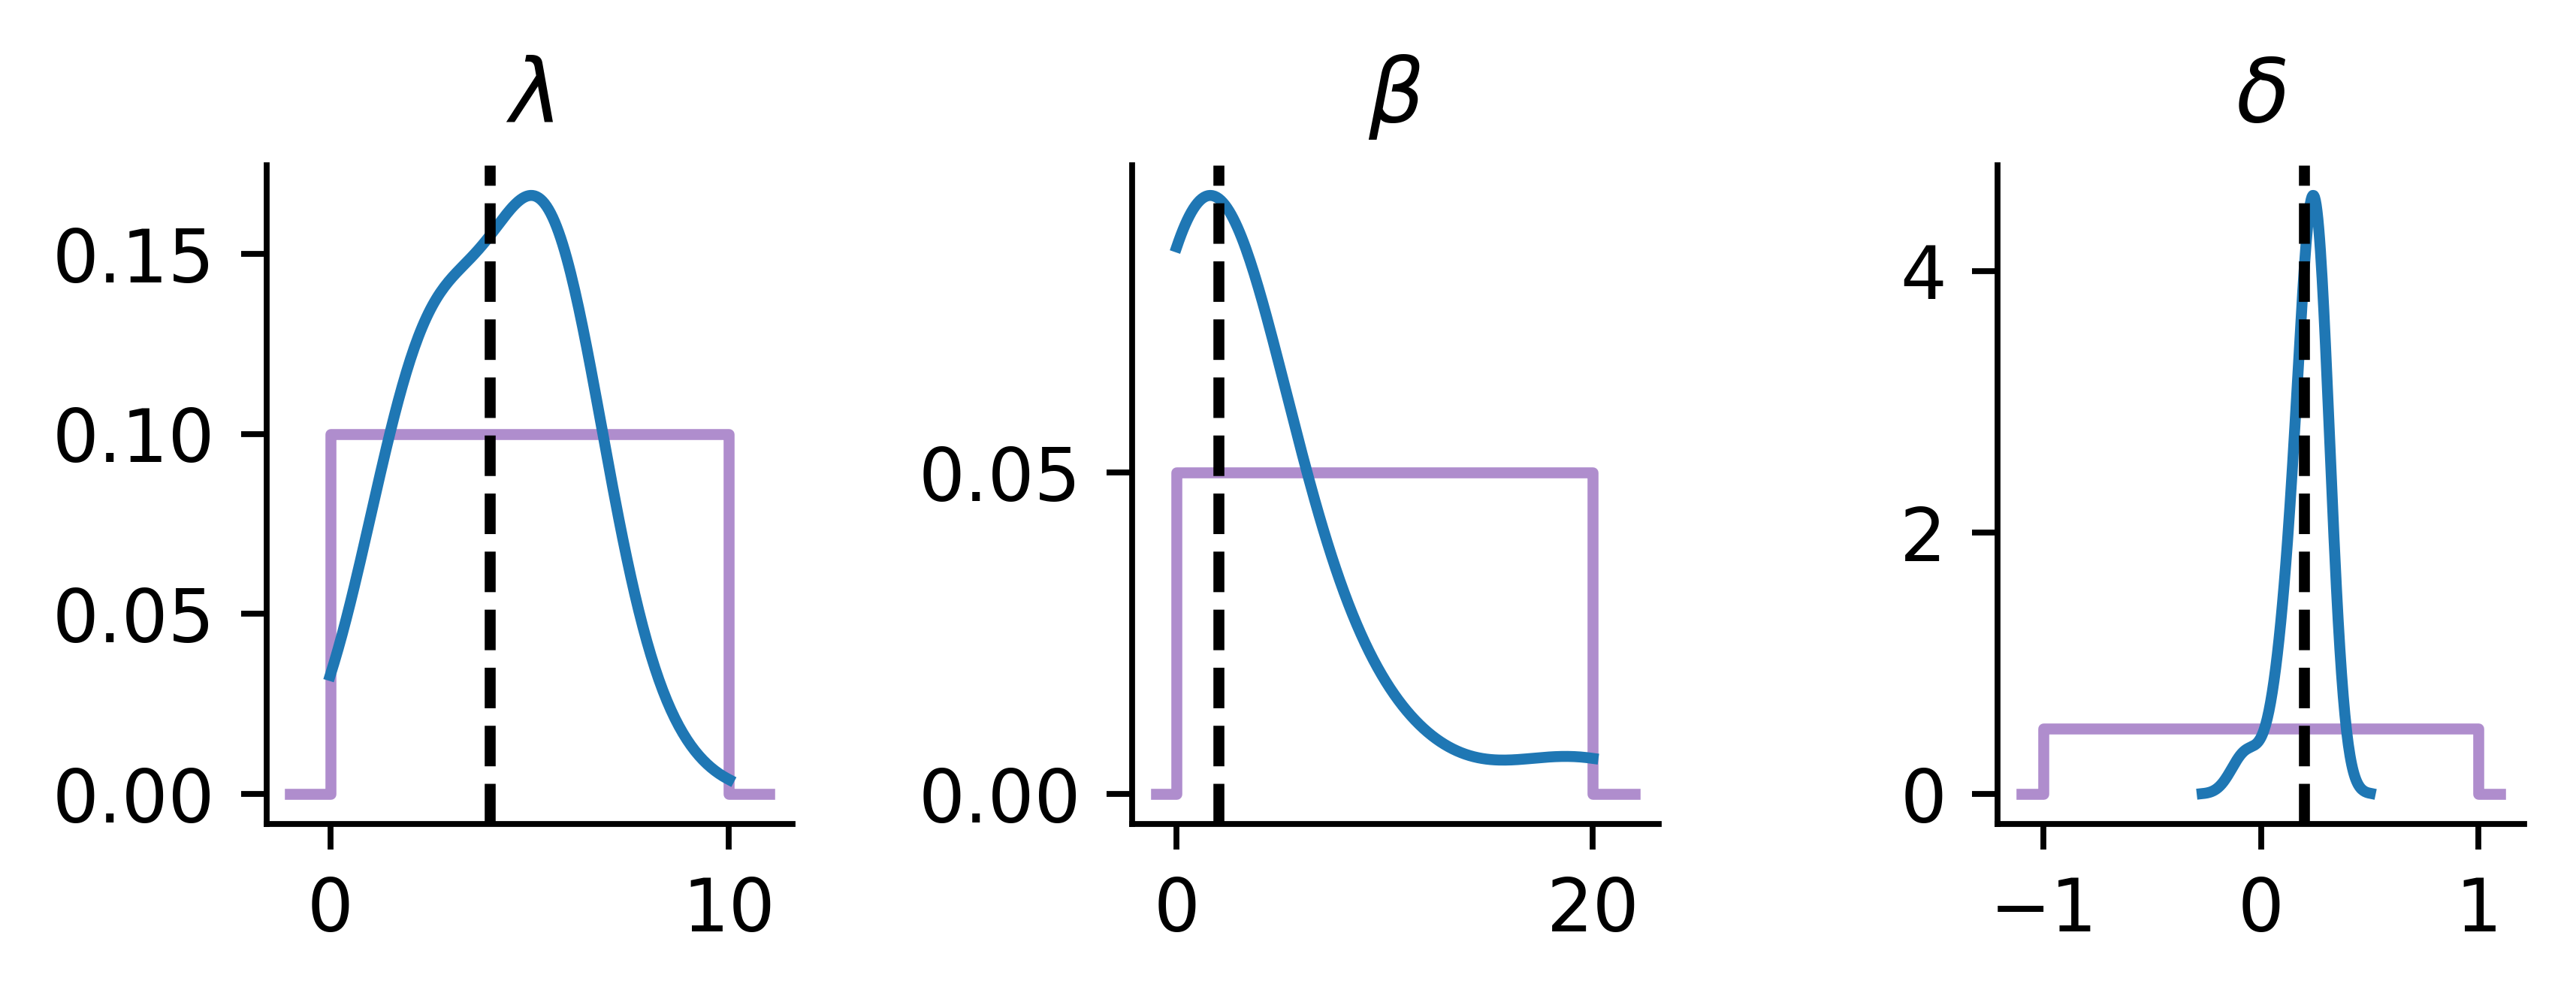

In [7]:
abc.plot_posteriors(
    fit, prior, subtitles=["$\\lambda$", "$\\beta$", "$\\delta$"], refLines=trueTheta
)

This quick fit managed to capture $\delta$ quite well, $\beta$ with moderate success, and $\lambda$ with slightly less success.

The observed data does have zeros, so enabling the `matchZeros` flag should increase the accuracy (and computation time) of the fits.

In [8]:
%time fitMatchZeros = abc.smc(numIters, popSize, xData, model, prior, matchZeros=True, seed=1)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 3min 37s, sys: 67.2 ms, total: 3min 37s
Wall time: 3min 37s


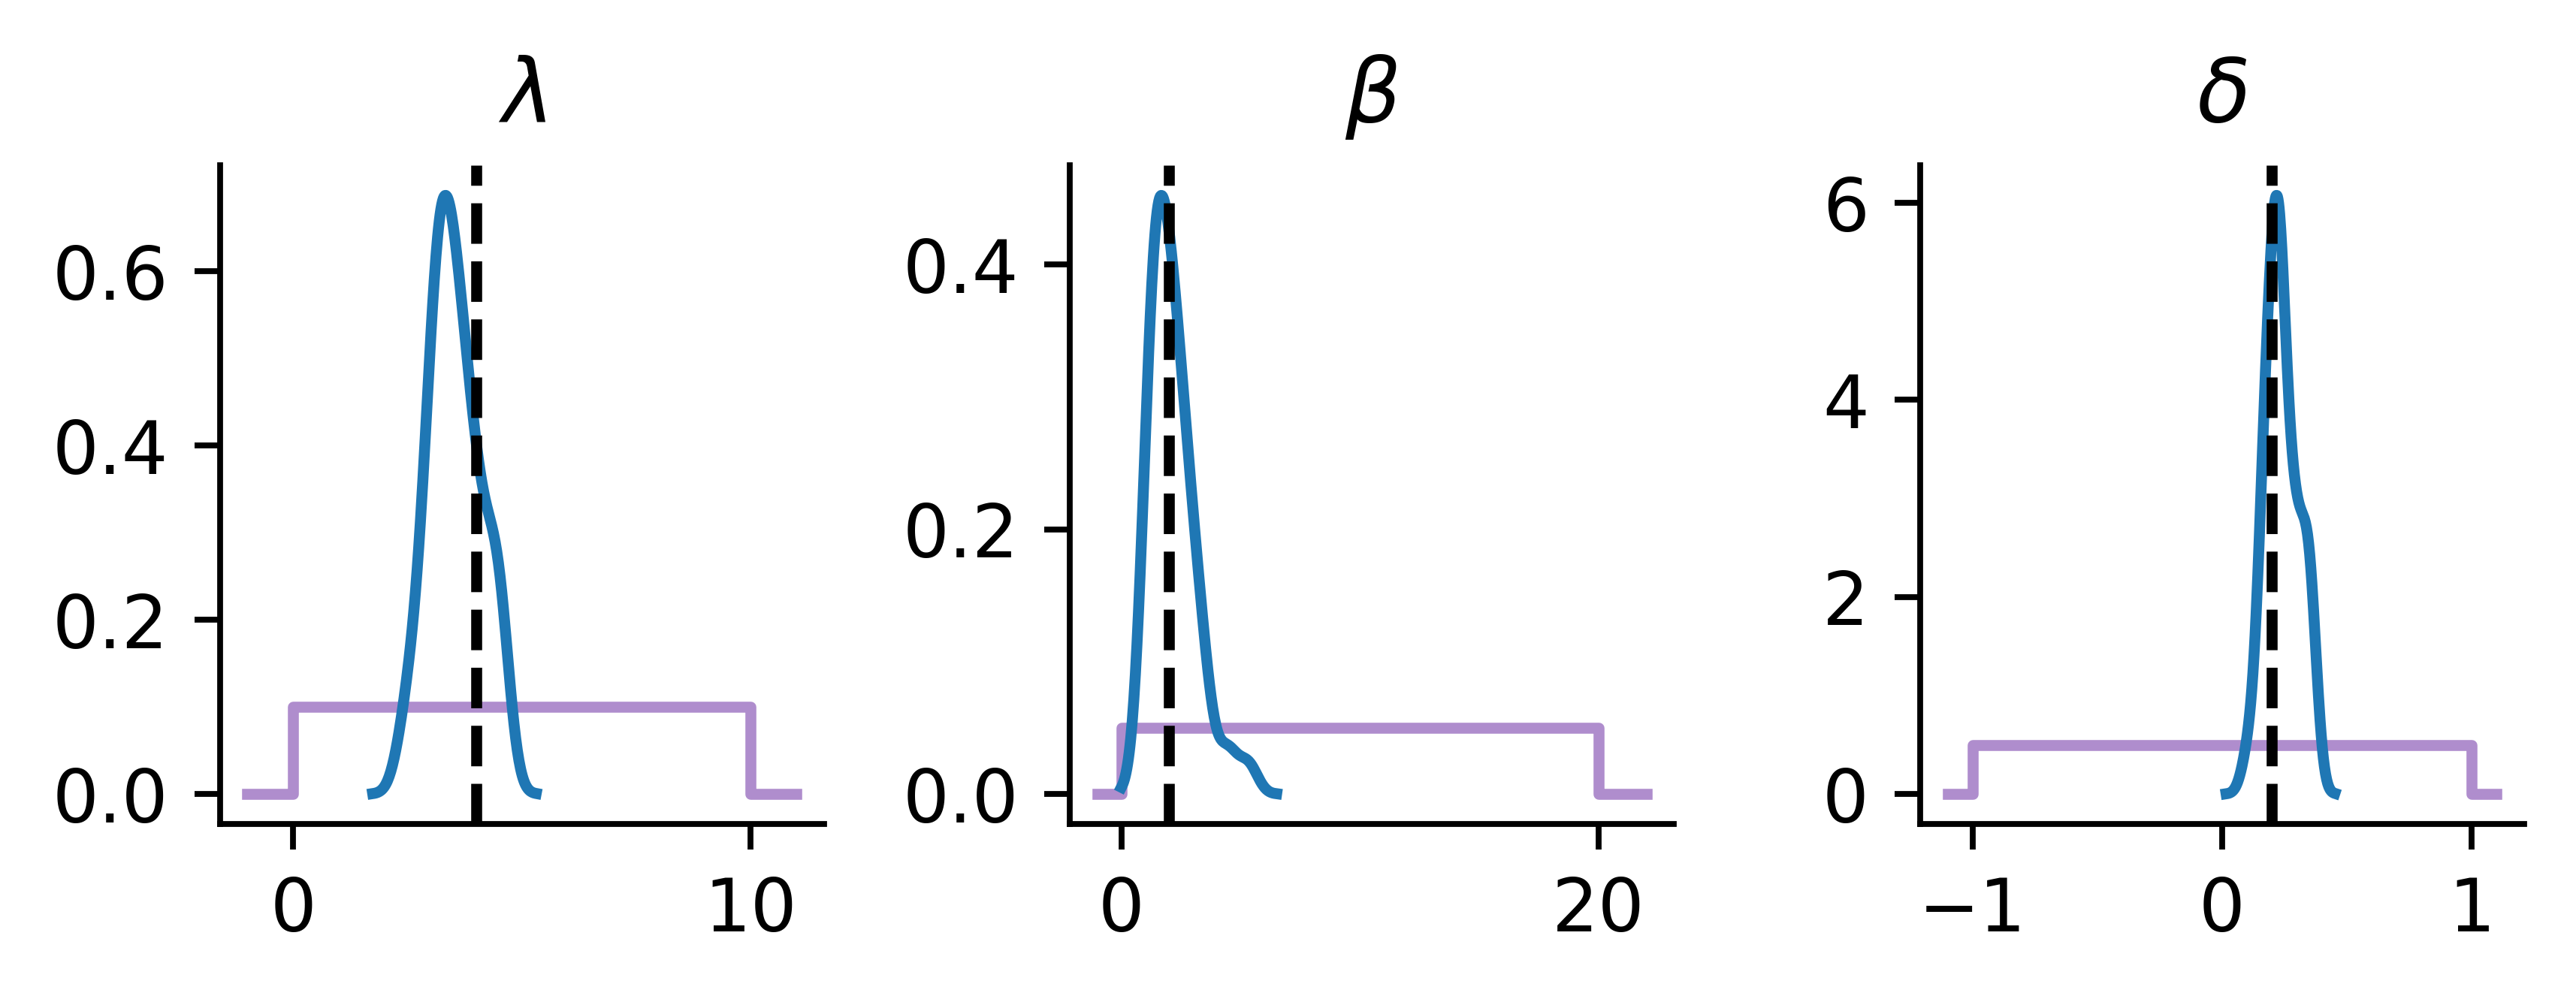

In [9]:
abc.plot_posteriors(
    fitMatchZeros,
    prior,
    subtitles=["$\\lambda$", "$\\beta$", "$\\delta$"],
    refLines=trueTheta,
)